In [1]:
#import darts
import pandas as pd
import numpy as np
#from darts import TimeSeries
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error as mape
#from sklearn.metrics import mean_squared_error as mse
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('Data/train_rental_demand.csv')#,parse_dates=['date'])
#test_df = pd.read_csv('Data/test_rental_demand.csv')

In [3]:
df['hour'] = df['hour'].apply(str)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  object
 2   demand  18247 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 427.8+ KB


In [5]:
df.loc[:,'Datetime'] = df['date'] + ' ' + df['hour']
from datetime import datetime
DateTime = []
for x in df['Datetime']:
    DateTime.append(datetime.strptime(x,'%Y-%m-%d %H'))
datetime = pd.Series(DateTime)
#df.index = datetime
#df = df.drop(['date','hour'],axis = 1,inplace=True)
#df = df.drop(['Datetime'],axis = 1)

In [6]:
df['datetime'] = datetime

In [7]:
df.drop(['date','hour'],axis = 1,inplace=True)
df.drop(['Datetime'],axis = 1,inplace=True)

In [8]:
df.head()

,demand,datetime
0,91,2018-08-18 09:00:00
1,21,2018-08-18 10:00:00
2,23,2018-08-18 13:00:00
3,104,2018-08-18 14:00:00
4,81,2018-08-18 15:00:00


In [9]:
#df['Datetime'] = pd.to_datetime(df['Datetime'],format='%Y-%m-%d %H')
#df['date'] = pd.to_datetime(df['date'])

df = (df.set_index('datetime')
        #.groupby('Serial_no')
        .apply(lambda x: x.asfreq('H')))
        #.drop('Serial_no', axis=1))
df = df.reset_index()
#df["Index"] = df.groupby("Serial_no").cumcount() + 1
print(df)

                 datetime  demand
0     2018-08-18 09:00:00    91.0
1     2018-08-18 10:00:00    21.0
2     2018-08-18 11:00:00     NaN
3     2018-08-18 12:00:00     NaN
4     2018-08-18 13:00:00    23.0
...                   ...     ...
22210 2021-02-28 19:00:00    95.0
22211 2021-02-28 20:00:00    88.0
22212 2021-02-28 21:00:00    39.0
22213 2021-02-28 22:00:00   104.0
22214 2021-02-28 23:00:00    85.0

[22215 rows x 2 columns]


In [10]:
df.head(10)

,datetime,demand
0,2018-08-18 09:00:00,91.0
1,2018-08-18 10:00:00,21.0
2,2018-08-18 11:00:00,NaN
3,2018-08-18 12:00:00,NaN
4,2018-08-18 13:00:00,23.0
5,2018-08-18 14:00:00,104.0
6,2018-08-18 15:00:00,81.0
7,2018-08-18 16:00:00,37.0
8,2018-08-18 17:00:00,27.0
9,2018-08-18 18:00:00,66.0


In [11]:
df1 = df.iloc[:,:].interpolate(method="polynomial", order=1)
#df2 = df.iloc[:,:].interpolate(method="polynomial", order=2)
#df3 = df.iloc[:,:].interpolate(method="polynomial", order=3)
# Write more about interpolation

In [12]:
df1

,datetime,demand
0,2018-08-18 09:00:00,91.000000
1,2018-08-18 10:00:00,21.000000
2,2018-08-18 11:00:00,21.666667
3,2018-08-18 12:00:00,22.333333
4,2018-08-18 13:00:00,23.000000
...,...,...
22210,2021-02-28 19:00:00,95.000000
22211,2021-02-28 20:00:00,88.000000
22212,2021-02-28 21:00:00,39.000000
22213,2021-02-28 22:00:00,104.000000


In [13]:
df1 = df1.rename(columns = {'demand' : 'y', 'datetime' : 'ds'})

In [14]:
train = df1.iloc[:18000]
test = df1.iloc[18000:]
train.head(15)

,ds,y
0,2018-08-18 09:00:00,91.000000
1,2018-08-18 10:00:00,21.000000
2,2018-08-18 11:00:00,21.666667
3,2018-08-18 12:00:00,22.333333
4,2018-08-18 13:00:00,23.000000
5,2018-08-18 14:00:00,104.000000
6,2018-08-18 15:00:00,81.000000
7,2018-08-18 16:00:00,37.000000
8,2018-08-18 17:00:00,27.000000
9,2018-08-18 18:00:00,66.000000


In [15]:
mm = Prophet()
mm.fit(train)

11:18:16 - cmdstanpy - INFO - Chain [1] start processing
11:18:19 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
mfuture = mm.make_future_dataframe(periods=4215,freq='h') # frequency as 15 minutes
mfuture

,ds
0,2018-08-18 09:00:00
1,2018-08-18 10:00:00
2,2018-08-18 11:00:00
3,2018-08-18 12:00:00
4,2018-08-18 13:00:00
...,...
22210,2021-02-28 19:00:00
22211,2021-02-28 20:00:00
22212,2021-02-28 21:00:00
22213,2021-02-28 22:00:00


In [17]:
mforecast = mm.predict(mfuture)
mforecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-18 09:00:00,64.452361,18.518712,110.785455,64.452361,64.452361,-1.280712,-1.280712,-1.280712,-2.220013,...,10.346982,10.346982,10.346982,-9.407682,-9.407682,-9.407682,0.0,0.0,0.0,63.171649
1,2018-08-18 10:00:00,64.453246,24.662153,113.483728,64.453246,64.453246,5.259851,5.259851,5.259851,3.945533,...,10.697317,10.697317,10.697317,-9.382999,-9.382999,-9.382999,0.0,0.0,0.0,69.713097
2,2018-08-18 11:00:00,64.454132,30.895753,121.478428,64.454132,64.454132,11.681145,11.681145,11.681145,10.018722,...,11.020765,11.020765,11.020765,-9.358342,-9.358342,-9.358342,0.0,0.0,0.0,76.135277
3,2018-08-18 12:00:00,64.455017,37.057333,124.764518,64.455017,64.455017,17.190607,17.190607,17.190607,15.209232,...,11.315086,11.315086,11.315086,-9.333712,-9.333712,-9.333712,0.0,0.0,0.0,81.645624
4,2018-08-18 13:00:00,64.455902,41.040313,132.808905,64.455902,64.455902,21.220043,21.220043,21.220043,18.950974,...,11.578179,11.578179,11.578179,-9.309110,-9.309110,-9.309110,0.0,0.0,0.0,85.675945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22210,2021-02-28 19:00:00,77.982696,47.985422,137.595738,77.219291,78.867490,16.448773,16.448773,16.448773,9.053701,...,3.241291,3.241291,3.241291,4.153781,4.153781,4.153781,0.0,0.0,0.0,94.431469
22211,2021-02-28 20:00:00,77.983570,43.332403,129.257784,77.219956,78.869142,9.574590,9.574590,9.574590,2.744311,...,2.651890,2.651890,2.651890,4.178389,4.178389,4.178389,0.0,0.0,0.0,87.558160
22212,2021-02-28 21:00:00,77.984445,36.179682,123.121406,77.220620,78.870795,3.289831,3.289831,3.289831,-2.981929,...,2.068888,2.068888,2.068888,4.202872,4.202872,4.202872,0.0,0.0,0.0,81.274276
22213,2021-02-28 22:00:00,77.985320,33.974657,116.228591,77.221284,78.872447,-1.551062,-1.551062,-1.551062,-7.273105,...,1.494814,1.494814,1.494814,4.227228,4.227228,4.227228,0.0,0.0,0.0,76.434257


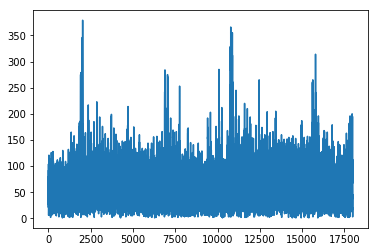

In [18]:
train['y'].plot()

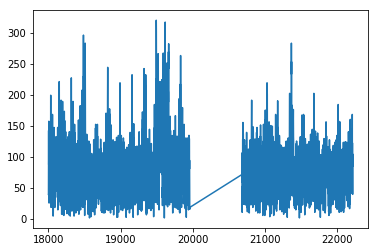

In [19]:
test['y'].plot() # y of test data

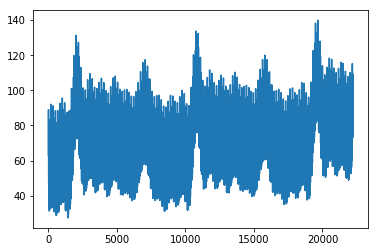

In [20]:
mforecast['yhat'].plot() # prophet y predict plot for test data

In [21]:
df1['day'] = df1['ds'].dt.day
df1['month'] = df1['ds'].dt.month
df1['year'] = df1['ds'].dt.year
df1['weekday'] = df1['ds'].dt.weekday
df1['hour'] = df1['ds'].dt.hour
df1['trend'] = mforecast['trend']
df1['additive_terms'] = mforecast['additive_terms']
df1['yearly'] = mforecast['yearly'] 
df1['weekly'] = mforecast['weekly']
df1['daily'] = mforecast['daily']


In [22]:
df1['rol_mean2'] = df1['y'].rolling(2).mean()
df1.dropna(inplace=True)

In [23]:
from xgboost import XGBRegressor

In [24]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tqdm.notebook import tqdm

In [25]:
df1.set_index('ds',inplace=True)

In [26]:
df1.index

DatetimeIndex(['2018-08-18 10:00:00', '2018-08-18 11:00:00',
               '2018-08-18 12:00:00', '2018-08-18 13:00:00',
               '2018-08-18 14:00:00', '2018-08-18 15:00:00',
               '2018-08-18 16:00:00', '2018-08-18 17:00:00',
               '2018-08-18 18:00:00', '2018-08-18 19:00:00',
               ...
               '2021-02-28 14:00:00', '2021-02-28 15:00:00',
               '2021-02-28 16:00:00', '2021-02-28 17:00:00',
               '2021-02-28 18:00:00', '2021-02-28 19:00:00',
               '2021-02-28 20:00:00', '2021-02-28 21:00:00',
               '2021-02-28 22:00:00', '2021-02-28 23:00:00'],
              dtype='datetime64[ns]', name='ds', length=22214, freq=None)

In [27]:
mforecast.iloc[15000,:]

ds                            2020-05-04 09:00:00
trend                                     71.6758
yhat_lower                                17.7228
yhat_upper                                102.151
trend_lower                               71.6758
trend_upper                               71.6758
additive_terms                            -12.458
additive_terms_lower                      -12.458
additive_terms_upper                      -12.458
daily                                    -2.22001
daily_lower                              -2.22001
daily_upper                              -2.22001
weekly                                   -3.66903
weekly_lower                             -3.66903
weekly_upper                             -3.66903
yearly                                   -6.56894
yearly_lower                             -6.56894
yearly_upper                             -6.56894
multiplicative_terms                            0
multiplicative_terms_lower                      0


In [28]:
#train_data = df1.iloc[:2020-05-04 09:00:00]
X_train = df1.loc[:'2020-05-04 09:00:00',:].drop('y',axis=1).values
y_train = df1.loc[:'2020-05-04 09:00:00','y'].values


In [29]:
#val_data = df1.loc[15000:18000]
X_val = df1.loc['2020-05-04 09:00:00':'2020-09-06 09:00:00',:].drop('y',axis=1).values
y_val = df1.loc['2020-05-04 09:00:00':'2020-09-06 09:00:00','y'].values


In [30]:
X_val

array([[   4.        ,    5.        , 2020.        , ...,   -3.66902643,
          -2.22001307,   84.        ],
       [   4.        ,    5.        , 2020.        , ...,   -4.00017902,
           3.9455325 ,  101.        ],
       [   4.        ,    5.        , 2020.        , ...,   -4.30577986,
          10.01872196,   86.        ],
       ...,
       [   6.        ,    9.        , 2020.        , ...,    9.79551062,
         -12.50231078,   29.5       ],
       [   6.        ,    9.        , 2020.        , ...,    9.34807295,
          -7.82114295,   39.83333333],
       [   6.        ,    9.        , 2020.        , ...,    8.87367676,
          -2.22001307,   42.        ]])

In [31]:
def hyperopt_objective(args):
    n_jobs = 2
    default_params = {"seed": 42}
    params = {
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
        'eval_metric':'rmse',
    }
    default_params.update(params)
    model = XGBRegressor(**default_params)

    eval_set = [(X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set,
               verbose=False)
    best_rmse = min(model.evals_result_['valid_0']['rmse'])
    return model

In [32]:
"""space = {
    "boosting": hp.pchoice("boosting", [(0.75, "gbdt"), (0.25, "dart")]),
    "learning_rate": 10 ** hp.uniform("learning_rate", -2, 0),
    "num_iterations": hp.quniform("num_iterations", 1, 1000, 1),
    "num_leaves": 2 ** hp.uniform("num_leaves", 1, 8),
    "max_depth": -1,
    "min_data_in_leaf": 2 * 10 ** hp.uniform("min_data_in_leaf", 0, 2),
    "min_sum_hessian_in_leaf": hp.uniform("min_sum_hessian_in_leaf", 1e-4, 1e-2),
    "bagging_fraction": hp.uniform("bagging_fraction", 0.5, 1.0),
    "bagging_freq": hp.qlognormal("bagging_freq", 0.0, 1.0, 1),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "extra_trees": hp.pchoice("extra_trees", [(0.75, False), (0.25, True)]),
    "lambda_l1": hp.lognormal("lambda_l1", 0.0, 1.0),
    "lambda_l2": hp.lognormal("lambda_l2", 0.0, 1.0),
    "path_smooth": hp.lognormal("path_smooth", 0.0, 1.0),
    "max_bin": 2 ** hp.quniform("max_bin", 6, 10, 1) - 1,
}"""
SEED = 42
def optimize(
             #trials, 
             random_state=SEED):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state
    }


    trials = Trials()

    best = fmin(fn=hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)